# Import modules

In [1]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os
import torch


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader


reproducibility.clear_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Plugins(categories=["generic"]).list()

assert device.type == 'cuda'


/home/bv292/miniconda/envs/test_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reload

In [2]:
import importlib
import DGE_experiments
import DGE_data
import DGE_utils
importlib.reload(DGE_experiments)
importlib.reload(DGE_data)
importlib.reload(DGE_utils)


<module 'DGE_utils' from '/home/bv292/synthcity/DGE_utils.py'>

# Load data and settings

In [3]:
from DGE_data import get_real_and_synthetic

datasets = ['adult', 'moons', 'circles','cal_housing', 'seer', 'cutract', 'diabetes', 'breast_cancer'] 
model_name = 'ctgan'  # synthetic data model
    
nsyn = None  # number of synthetic data points per synthetic dataset. Defaults to same as generative training size if None
p_train = None  # proportion of training data for generative model. Default values if None
n_models = 20  # number of models in ensemble
max_n = 2000 # maximum number of data points to use for training generative model.

load = True  # results
load_syn = True  # data
save = True  # save results and data

verbose = False

for dataset in datasets:
    print('Dataset:', dataset)
    workspace_folder = os.path.join("workspace", dataset,model_name)
    results_folder = os.path.join("uncertainty_results",dataset,model_name)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        p_train=p_train,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n)


    nsyn = len(X_syns[0])
    print('Shape of each synthetic dataset:', X_syns[0].shape)
    print('Target type:', X_gt.targettype)


Dataset: adult
n_total 32561 n_train: 2000
Shape of each synthetic dataset: (2000, 14)
Target type: classification
Dataset: moons
n_total 10000 n_train: 1000
Shape of each synthetic dataset: (1000, 3)
Target type: classification
Dataset: circles
n_total 10000 n_train: 1000
Shape of each synthetic dataset: (1000, 3)
Target type: classification
Dataset: cal_housing
n_total 20640 n_train: 2000
Shape of each synthetic dataset: (2000, 9)
Target type: regression
Dataset: seer
n_total 20000 n_train: 2000
Shape of each synthetic dataset: (2000, 7)
Target type: classification
Dataset: cutract
n_total 20000 n_train: 2000
Shape of each synthetic dataset: (2000, 7)
Target type: classification
Dataset: diabetes
n_total 442 n_train: 265
Shape of each synthetic dataset: (265, 11)
Target type: regression
Dataset: breast_cancer
n_total 569 n_train: 341
Shape of each synthetic dataset: (341, 31)
Target type: classification


# Analyses

## Model Training

n_total 32561 n_train: 2000
Dataset adult

\begin{tabular}{lrrrrrrr}
\toprule
{} &       AUC &       Acc &        F1 &  Precision &    Recall &       NLL &     Brier \\
\midrule
DGE (k=20)              &  0.893000 &  0.841000 &  0.624000 &   0.721000 &  0.550000 &  0.344000 &  0.110000 \\
DGE (k=10)              &  0.892000 &  0.842000 &  0.632000 &   0.718000 &  0.564000 &  0.346000 &  0.110000 \\
DGE (k=5)               &  0.887000 &  0.835000 &  0.641000 &   0.674000 &  0.611000 &  0.353000 &  0.113000 \\
Naive (single)          &  0.871000 &  0.816000 &  0.637000 &   0.607000 &  0.669000 &  0.382000 &  0.123000 \\
Naive (ensemble)        &  0.872000 &  0.819000 &  0.638000 &   0.615000 &  0.662000 &  0.378000 &  0.123000 \\
Naive (concat)          &  0.889000 &  0.835000 &  0.639000 &   0.675000 &  0.606000 &  0.348000 &  0.112000 \\
Oracle (single)         &  0.888000 &  0.840000 &  0.633000 &   0.707000 &  0.573000 &  0.355000 &  0.112000 \\
Oracle (ensemble)       &  0.889000 & 

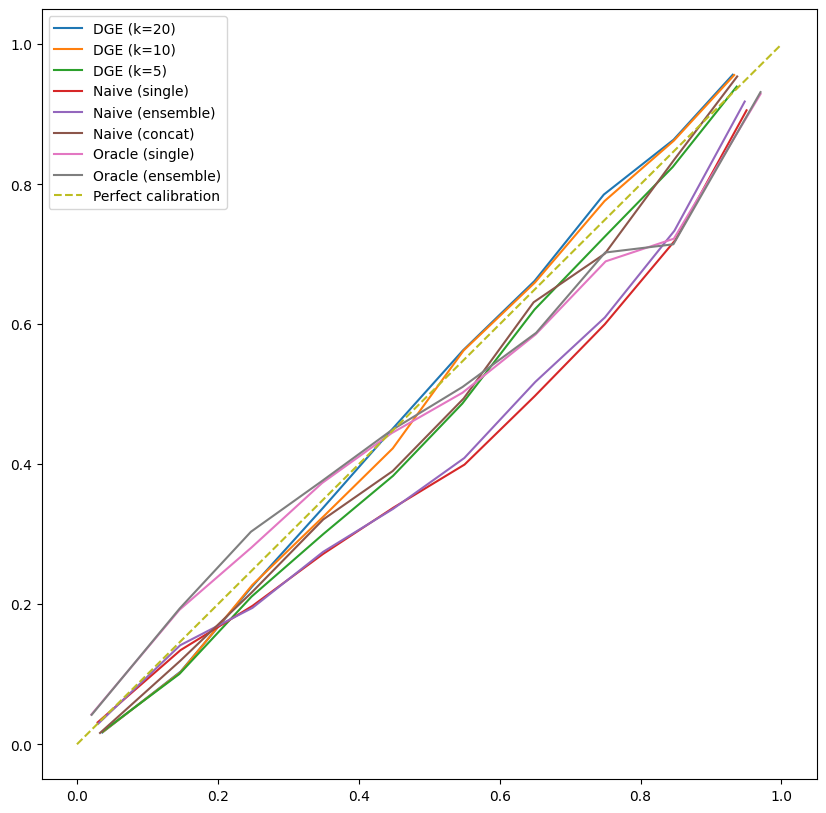

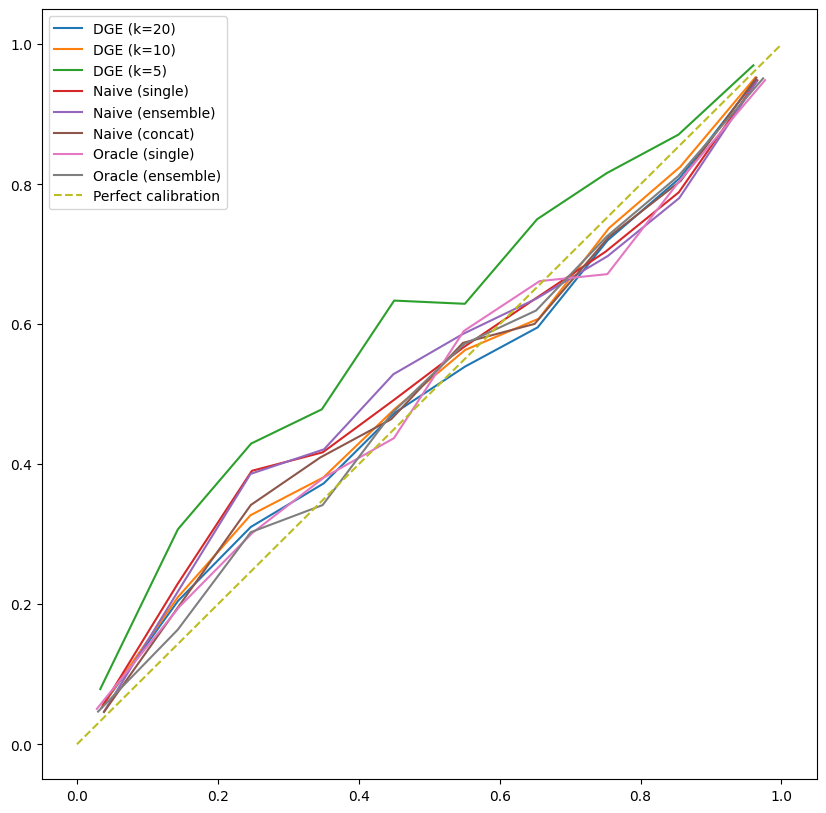

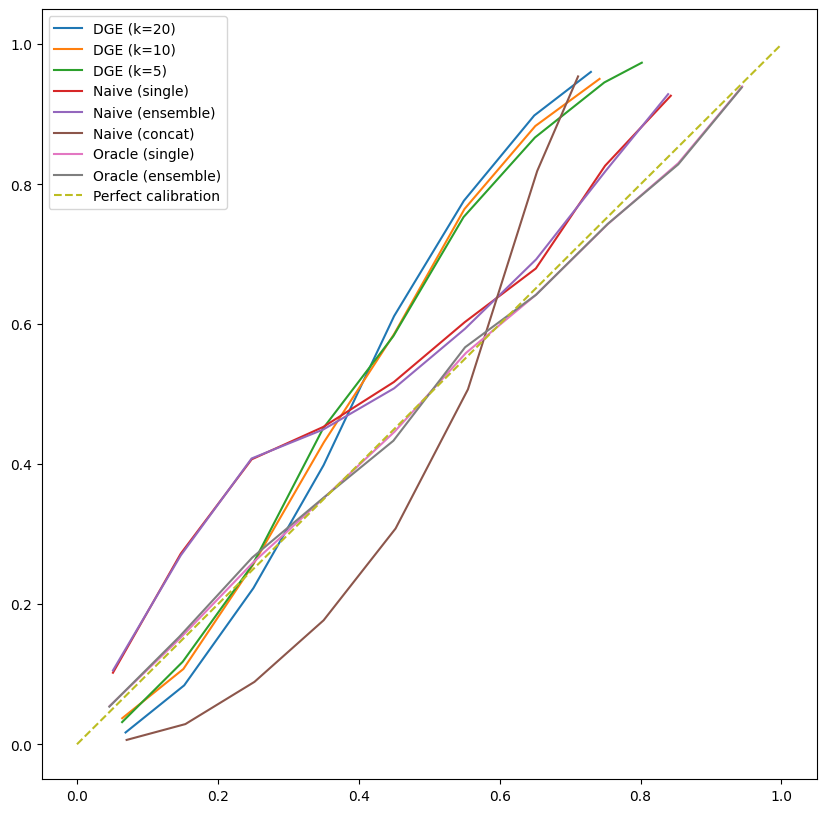

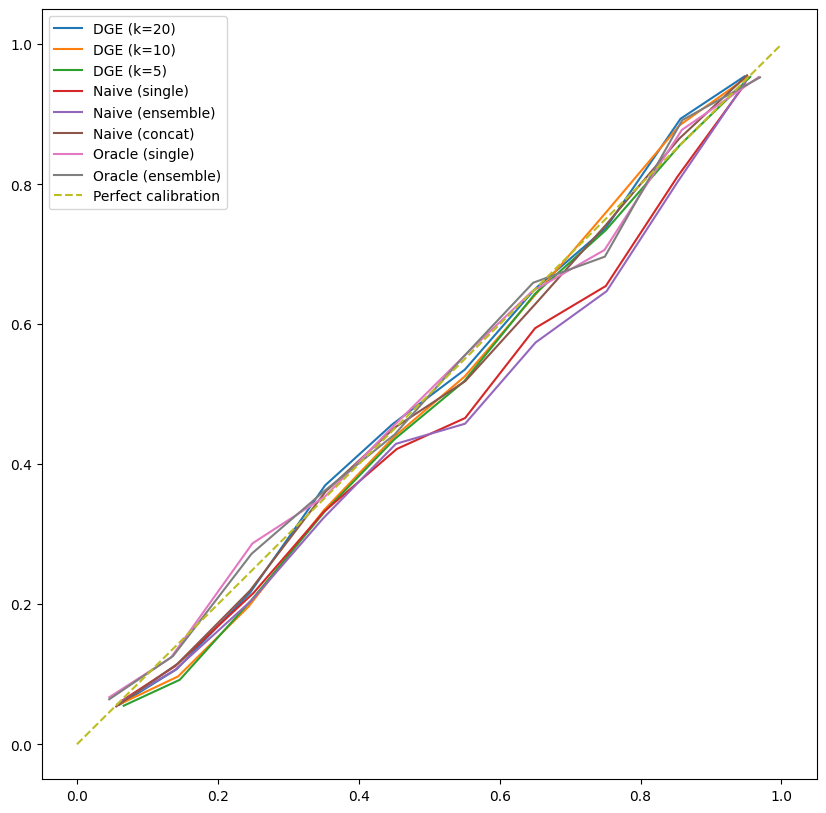

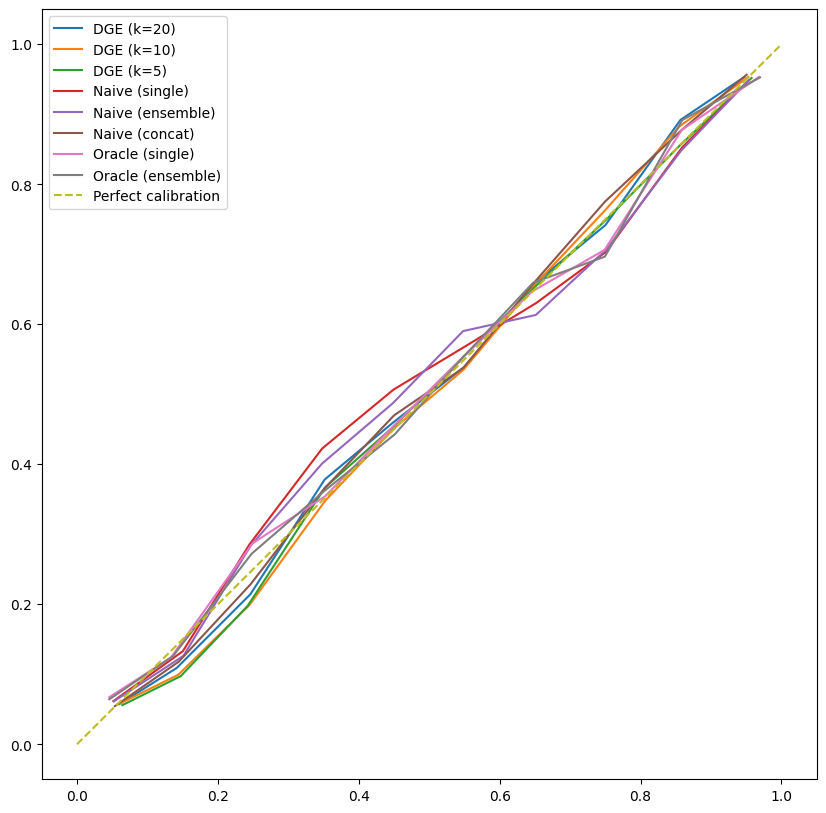

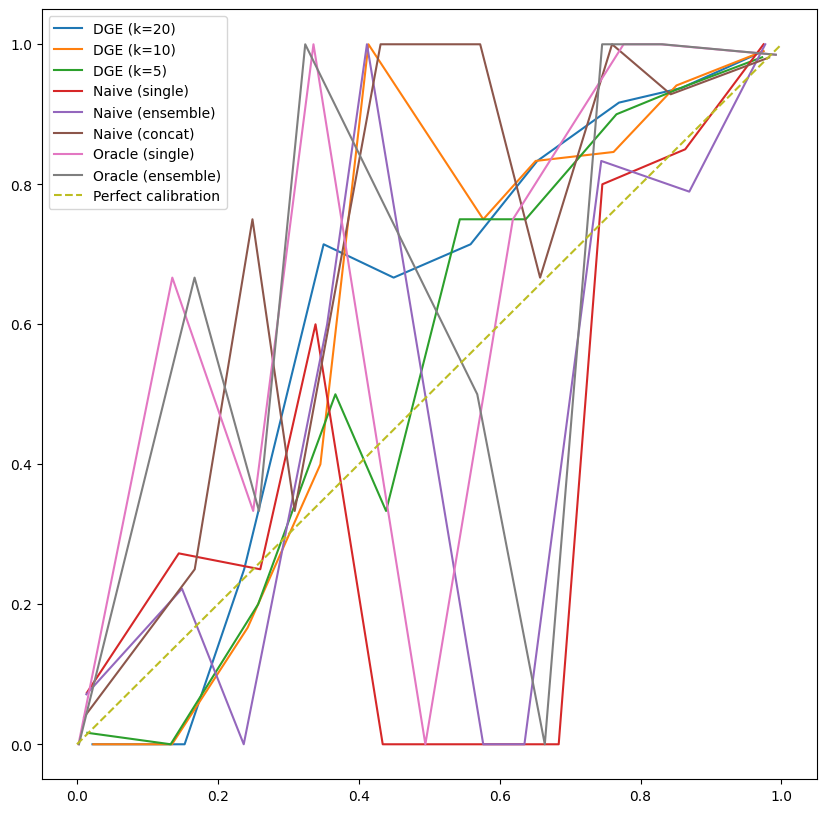

In [10]:
from DGE_experiments import predictive_experiment
import pandas as pd


all_scores = []
class_datasets = []
dataset_type = 'classification'

for dataset in datasets:
    workspace_folder = os.path.join("workspace", dataset,model_name)
    results_folder = os.path.join("uncertainty_results",dataset,model_name)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                        p_train=p_train,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n)
    if X_gt.targettype != dataset_type:
        continue
    else:
        class_datasets.append(dataset)
    
    print(f'Dataset {dataset}\n')
    
    y_preds, scores = predictive_experiment(X_gt,
                      X_syns,
                      workspace_folder=workspace_folder,
                      results_folder=results_folder,
                      save=save,
                      load=load,
                      #ensemble_baseline=True,
                      )

    print(scores.to_latex())

    all_scores.append(scores)

print('All scores:')

def mean_across_pandas(dfs):
    dfs = pd.concat(dfs)
    df_mean = dfs.groupby(level=0).mean()
    return df_mean

df_mean = mean_across_pandas(all_scores)
df_mean.round(3)
print(df_mean.to_latex())

n_total 20000 n_train: 2000


array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'psa'}>,
        <AxesSubplot: title={'center': 'comorbidities'}>],
       [<AxesSubplot: title={'center': 'treatment'}>,
        <AxesSubplot: title={'center': 'grade'}>,
        <AxesSubplot: title={'center': 'stage'}>],
       [<AxesSubplot: title={'center': 'target'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

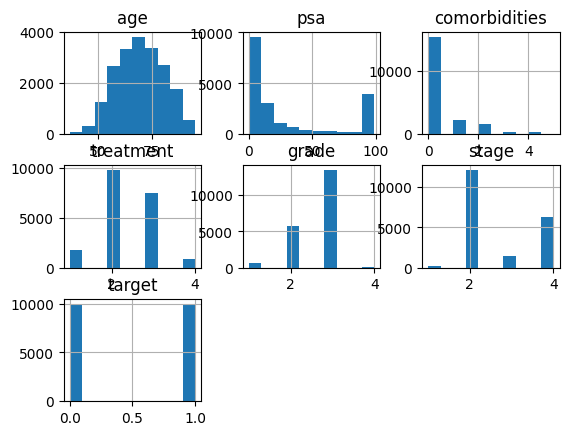

In [27]:
X_gt, X_syns = get_real_and_synthetic(dataset='cutract',
                                        p_train=p_train,
                                        n_models=n_models,
                                        model_name=model_name,
                                        load_syn=load_syn,
                                        verbose=verbose,
                                        max_n=max_n)
X_gt.data.hist()

In [24]:
# use scores but report per dataset
metric = 'AUC'

df_all_datasets = pd.concat([score[metric] for score in all_scores], axis=1)
df_all_datasets.columns = class_datasets
df_all_datasets.round(3)

for dataset in zip(['moons', 'circles', 'adult', 'breast_cancer', 'seer', 'cutract'][::-1], 
        ['Moons', 'Circles', 'Adult Income', 'Breast Cancer', 'SEER', 'CUTRACT'][::-1]):
    df_all_datasets.insert(0, dataset[1], df_all_datasets.pop(dataset[0]))
df_all_datasets['Mean'] = df_all_datasets.mean(axis=1)
print(df_all_datasets.to_latex(float_format=lambda x: '%.3f' % x))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Moons &  Circles &  Adult Income &  Breast Cancer &  SEER &  CUTRACT &  Mean \\
\midrule
DGE (k=20)              &  0.914 &    0.869 &         0.893 &          0.987 & 0.907 &    0.907 & 0.913 \\
DGE (k=10)              &  0.916 &    0.863 &         0.892 &          0.989 & 0.907 &    0.907 & 0.912 \\
DGE (k=5)               &  0.918 &    0.862 &         0.887 &          0.983 & 0.907 &    0.906 & 0.910 \\
Naive (single)          &  0.914 &    0.800 &         0.871 &          0.962 & 0.902 &    0.901 & 0.892 \\
Naive (ensemble)        &  0.914 &    0.797 &         0.872 &          0.965 & 0.904 &    0.902 & 0.892 \\
Naive (concat)          &  0.923 &    0.863 &         0.889 &          0.978 & 0.910 &    0.910 & 0.912 \\
Oracle (single)         &  0.938 &    0.869 &         0.888 &          0.996 & 0.911 &    0.911 & 0.919 \\
Oracle (ensemble)       &  0.938 &    0.870 &         0.889 &          0.996 & 0.911 &    0.911 & 0.919 \\
Naive (single)

# Model Evaluation

We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow.
0. Train and generate synthetic datasets $S_i$.
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic dataset's test set $S_{i,test}$, giving $\hat{M}^S_i$ [Single performance]
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle performance]
5. Evaluate on the other synthetic datasets $\cup_{j\neq i} S_{j}$, giving $\hat{M}^G_i$ [Generative performance]
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average over all models $f_i$. 
7. Repeat 1-6 for different model classes $f$

N.B. the idea of the above, is that the trained model $f_i$ is the same for each evaluation type. In the model selection section, we will compare the performance of different model classes, where we will train a new model for each evaluation type (hence the aim is to evaluate which class is best, while the model itself may vary).

In [5]:
from DGE_experiments import model_evaluation_experiment

if X_gt.targettype is not None:
    print('Aggregate approaches:')
    res = model_evaluation_experiment(X_gt, X_syns, workspace_folder=workspace_folder, model_type='mlp')[0]
    print(res)


Aggregate approaches:
                 AUC           Acc            F1     Precision        Recall  \
oracle  97.58 ± 0.89  92.22 ± 2.02  93.66 ± 1.83  95.01 ± 1.67  92.51 ± 4.15   
naive    95.6 ± 2.66  89.57 ± 3.84  90.15 ± 3.84  89.95 ± 4.61  90.56 ± 5.26   
dge     94.73 ± 0.71   87.68 ± 0.8  88.46 ± 0.73   88.1 ± 2.49   88.98 ± 2.8   

                 NLL        Brier  
oracle  22.56 ± 7.86  5.81 ± 1.45  
naive   31.5 ± 14.14  8.36 ± 3.18  
dge     37.62 ± 4.22  9.57 ± 0.64  


# Model Selection
Essentially repeat the above for different models

In [6]:
from DGE_experiments import model_selection_experiment

if X_gt.targettype is not None:
    if X_gt.targettype == 'classification':
        metric = 'Acc'
    elif X_gt.targettype == 'regression':
        metric = 'MAE'
    
    results, means_sorted = model_selection_experiment(X_gt, X_syns, relative=False, metric=metric, workspace_folder=workspace_folder, load=load, save=save)


print(results.to_latex())

Train model 1/20


IndexError: index 113985 is out of bounds for axis 0 with size 272

## Influence of synthetic data size

Let's study the effect of synthetic data size.

In [ ]:
from DGE_experiments import predictive_varying_nsyn

predictive_varying_nsyn(X_gt, X_syns, dataset, model_name, n_models,
                        nsyn, results_folder, workspace_folder, load, save, verbose=True)


## Density estimation


In [ ]:
from DGE_experiments import density_experiment

if X_gt.targettype is None:
    density_experiment(X_gt, X_syns, load, save)


# Model parameter estimation
Using a linear model

# Cross validation

We compare the single baseline model vs the generative uncertainty model. Single workflow
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic datasets test set $S_{i,test}$
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $\hat{M}_i$
5. Average results across the different synthetic datasets, giving $M_i$.
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average.

Versus our baseline
1. Take each synthetic dataset $S_i$ and split it up in train and test
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic datasets test set $S_{i,test}
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $\hat{M}_i$
5. Average results across the different synthetic datasets, giving $M_i$.
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average.


Cross-validation approach to test which type of model would perform best on real data. We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow Cross-validation.
0. Train and generate synthetic datasets $S_i$.
1. Use CV to train and evaluate models $f_i$ on each $S_i$. Repeat for all $S_i$. [Single performance]
2. Use CV \textit{over datasets $S_i$} (i.e. train on all but one $S_i$, evaluate on remaining and repeat) to train and evaluate models $f_i$.
3. For both cases, evaluate the model also on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle performance]
4. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average over all models $f_i$. 